## Sampling Pointcloud and extracting features for the sampled data

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
import ipywidgets as widgets

import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.insert(0, parent_dir)

import os
import pickle as pkl
import numpy as np
import pcl
from PIL import Image

from lib.custom_dataloader import Dataset
from torch.utils.data import DataLoader
from lib.seg_utils import dpt_2_cld,draw_p2ds,project_p3d
import matplotlib.pyplot as plt

root_path = "/media/kulunu/Elements SE/Datasets/Nema17_reducer_dataset"

seg_format = '.npy'
img_id_leading_zeros = 0
dpt_format = ".png"
rgb_format = ".png"

dataset = Dataset(root_path, scene_id ='stage_1')
cld_rgb_nrms_path = os.path.join(dataset.dir, 'cld_rgb_nrms')

### Sample and Extract features

In [ ]:
# this part runs on pvn3d
# TODO:Only run the calculations if the folders are empty

def get_normal( cld):
        cloud = pcl.PointCloud()
        cld = cld.astype(np.float32)
        cloud.from_array(cld)
        ne = cloud.make_NormalEstimation()
        kdtree = cloud.make_kdtree()
        ne.set_SearchMethod(kdtree)
        ne.set_KSearch(50)
        n = ne.compute()
        n = n.to_array()
        return n

rgb_directory = os.path.join(dataset.dir,'rgb')
for filename in os.listdir(rgb_directory):
    name, extension = os.path.splitext(filename)

    idx = name.lstrip('0')
    idx = int(idx) if idx else 0

    K,dpt_K, cam_scale = dataset.get_cam_info(idx)
    
    segmap = np.load(os.path.join(dataset.segmap_dir,str(idx).zfill(img_id_leading_zeros)+'_seg_map'+seg_format))
    segmap_flattened = segmap.flatten()
    
    with Image.open(os.path.join(dataset.dpt_dir,str(idx).zfill(img_id_leading_zeros)+ dpt_format)) as di:
        dpt = np.array(di)
        
    with Image.open(os.path.join(dataset.rgb_dir,str(idx).zfill(img_id_leading_zeros)+ rgb_format)) as ri:
                rgb = np.array(ri)[:, :, :3]
                rgb = np.transpose(rgb, (2, 0, 1))


    #Back-projection util function
    cld, choose = dpt_2_cld(dpt, dpt_K)
 
    # load precalculated segmaps or labels   
    segmap_flattened = segmap_flattened[choose]

    # sample only 12288 points and get the respective cld_rgb_nrm + labels
    rgb_lst = []
    for ic in range(rgb.shape[0]):
        rgb_lst.append(
            rgb[ic].flatten()[choose].astype(np.float32)
        )
     
    rgb_pt = np.transpose(np.array(rgb_lst), (1, 0)).copy()
    
    
    choose = np.array([choose], dtype= np.uint32)
    choose_2 = np.array([i for i in range(len(choose[0, :]))])
    
    
    if len(choose_2) < 400:
        print("not_enough points")
        
    if len(choose_2) > dataset.n_sample_points:
        c_mask = np.zeros(len(choose_2), dtype=int)
        c_mask[:dataset.n_sample_points] = 1
        np.random.shuffle(c_mask)
        choose_2 = choose_2[c_mask.nonzero()]
    else:
        choose_2 = np.pad(choose_2, (0, dataset.n_sample_points-len(choose_2)), 'wrap')
    
    # select only the sampled indexes    
    rgb_pt = rgb_pt[choose_2,:]  
    cld = cld[choose_2, :]

    normals = get_normal(cld)[:,:3]
    normals[np.isnan(normals)] = 0.

    cld_rgb_nrm = np.concatenate((cld, rgb_pt, normals), axis=1)
    
    # labels are the corresponding per sampled point, segmap is the perpoint labels for all points
    labels = segmap_flattened[choose_2].astype(np.int32)
    
    #save the choose with each label 
    choose = np.squeeze(choose[:, choose_2])
    arr = [labels,choose]

    label_path = os.path.join(dataset.dir, 'labels')
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    if not os.path.exists(os.path.join(label_path,str(idx)+'.npy')):
        np.save(os.path.join(label_path,str(idx)+'.npy'), arr)  # NOTE! Only label is saved. you can save arr next time!
    #all_arr = np.concatenate( (cld, choose.reshape(choose.shape[0],1), normals[:,:3]) , axis = 1)
    
    if not os.path.exists(cld_rgb_nrms_path):
        os.makedirs(cld_rgb_nrms_path)
    
    if not os.path.exists(os.path.join(cld_rgb_nrms_path,str(idx)+'.pkl')):
        print('Writing file '+str(idx)) 
        with open(os.path.join(cld_rgb_nrms_path,str(idx)+'.pkl'), 'wb') as file:
            pkl.dump(cld_rgb_nrm,file)


### Always visualize data to confrim

In [ ]:
# TODO : Visualize random data, 4 tiles
idx = 7
data_torch = dataset.get_item(idx=idx)

cu_dt = [item.contiguous().to("cuda", non_blocking=True) for item in data_torch]    
labels, cld_rgb_nrm, choose, rgb  = cu_dt

pcld = cld_rgb_nrm.squeeze().cpu().numpy()[:,0:3]
labels = labels.squeeze().cpu().numpy()
rgb = rgb.cpu().numpy().transpose(1, 2, 0)[...,::-1].copy()

K,dpt_K, cam_scale = dataset.get_cam_info(idx=idx)

color = (255,0,0)
p2ds = project_p3d(pcld[labels == 1], cam_scale, K)
rgb = draw_p2ds(rgb, p2ds,color,3)

plt.figure(figsize=(30,30))
plt.imshow(np.asarray(rgb,np.int32),interpolation='none')
plt.show()  

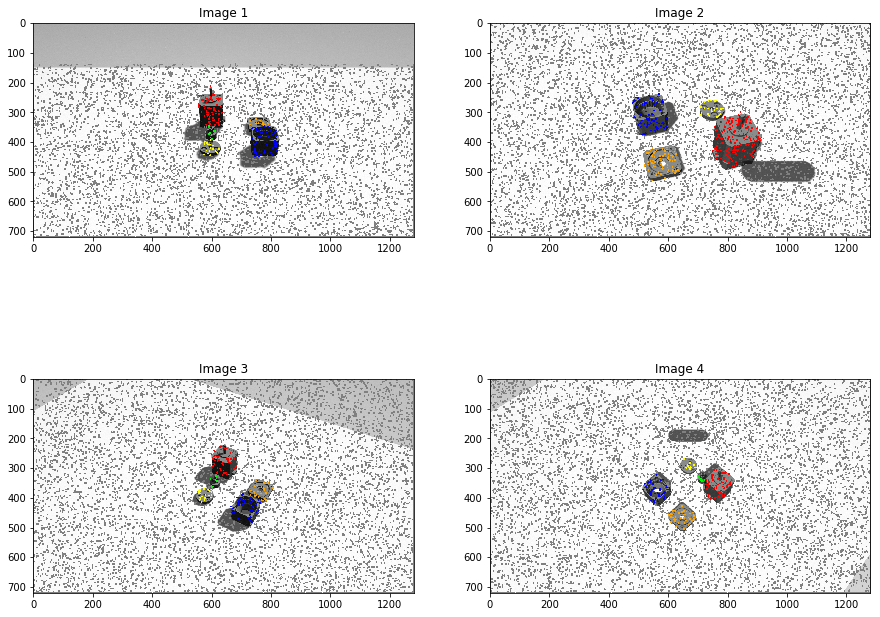

In [18]:
# TODO : The processing takes longer.
num_images = 4
rows = 2
cols = 2
fig = plt.figure(figsize=(15,12))

dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)
K,dpt_K, cam_scale = dataset.get_cam_info(idx=0)
labels, cld_rgb_nrm, choose, rgb = next(iter(dataloader))

colors = [
    (128, 128, 128),  # Grey
    (255, 0, 0),      # Red
    (0, 255, 0),      # Green
    (0, 0, 255),      # Blue
    (255, 255, 0),    # Yellow
    (255, 165, 0)     # Orange
]

for idx in range(num_images):
    
    pcld = cld_rgb_nrm[idx].squeeze().cpu().numpy()[:,0:3].copy()
    label = labels[idx].squeeze().cpu().numpy().copy()
    rgb_ = rgb[idx].cpu().numpy().transpose(1, 2, 0)[...,::-1].copy()

    for i in range(0, len(np.unique(labels))):
         p2ds = project_p3d(pcld[label == i], cam_scale, K)
         rgb_ = draw_p2ds(rgb_, p2ds,colors[i],3)

    ax = fig.add_subplot(rows, cols, idx + 1)
    plt.imshow(np.asarray(rgb_,np.int32),interpolation='none')
    ax.set_title(f"Image {idx + 1}")

plt.show()
    

In [ ]:
# TODO : Create a visualization gif
